# Navigation



### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.9 which is incompatible.


Load the environment

In [2]:
from unityagents import UnityEnvironment
import numpy as np


env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]

### 2. Perform Online Training


Define a function that trains the agent in the enviroment.

The function trains the agent in the environment for the given number of episodes. The epsilon parameter is adjusted within the this function. 

In [10]:
def run_online_training(agent,n_episodes, epsilon_start, epsilon_decay, epsilon_min):

    from collections import deque
    import matplotlib.pyplot as plt 
    import torch
    
    epsilon = epsilon_start
    scores = []                                        # all scores during exectuition
    scores_average = []                                # moving average
    scores_100 = deque(maxlen=100)                     # last 100 scores
    solved = False

    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0                                          # initialize the score

        t=0
        while True:
            action = agent.act(state = state, eps = epsilon)             # select an 
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            score += reward                                # update the score
            agent.step(state, action, reward, next_state, done)
            state = next_state                             # roll over the state to next time step
            epsilon = max(epsilon_min , epsilon * epsilon_decay)
            t += 1


            if done:                                       # exit loop if episode finished
                break


        scores.append(score)
        scores_100.append(score)
        scores_average.append(np.mean(scores_100))
        if(i_episode==1 or i_episode%100 == 0 ):
            print("Episode: {} , Moving Average Score: {}".format(i_episode, np.mean(scores_100)))
        if np.mean(scores_100) >= 13 and i_episode >= 100 and solved == False:
            solved = True
            solved_in = i_episode
            print("Environment solved in {} episodes".format(solved_in))
            torch.save(agent.qnetwork_local.state_dict(), 'WeightsAtSolved.pth')


    if solved == False:
        print("Environnment not solved")
    else:
        torch.save(agent.qnetwork_local.state_dict(), 'FinalWeights.pth')
    
    return scores, scores_average

Load the agent from agent.py and run online training.

The agent uses a dueling network architecture defined in model.py to estimate Q.



In [11]:
from agent import Agent
agent = Agent(state_size= len(env_info.vector_observations[0]), 
              action_size= brain.vector_action_space_size, 
              seed=0, 
              double_update = True,
              buffer_size = int(1e5),
              batch_size = 64,
              gamma = 0.99,
              tau = 1e-3,
              lr = 5e-4,
              update_every = 4)
    
scores, scores_average = run_online_training(agent = agent, n_episodes = 700, epsilon_start = 0.1, epsilon_decay = 0.99, epsilon_min =0.01)

Episode: 1 , Moving Average Score: -1.0
Episode: 100 , Moving Average Score: 3.27
Episode: 200 , Moving Average Score: 6.62
Episode: 300 , Moving Average Score: 9.9
Environment solved in 381 episodes
Episode: 400 , Moving Average Score: 13.99
Episode: 500 , Moving Average Score: 15.49
Episode: 600 , Moving Average Score: 16.12
Episode: 700 , Moving Average Score: 15.62


### 3. Results

Plot the scores and moving average against the episode 

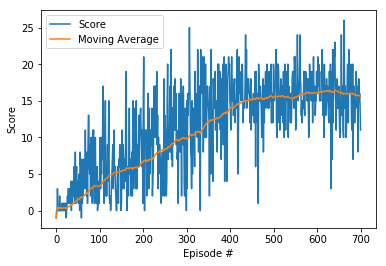

In [12]:
# plot the scores
import matplotlib.pyplot as plt 
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label = "Score")
plt.plot(np.arange(len(scores_average)), scores_average, label = "Moving Average")
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()